In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D, Dropout, ReLU, Add, BatchNormalization, Multiply, GlobalAveragePooling2D, Reshape,DepthwiseConv2D
from keras.optimizers import Adam
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.metrics import Metric,Precision, Recall
import cv2
import numpy as np

In [2]:
train_dir = r'E:\MV\coursework\fruits-360\Training'
test_dir = r'E:\MV\coursework\fruits-360\Test'
#The total number of images: 90483.
#Training set size: 67692 images (one fruit or vegetable per image).
#Test set size: 22688 images (one fruit or vegetable per image).
#The number of classes: 131 (fruits and vegetables).
#Image size: 100x100 pixels.

In [3]:
#find out the total calsses of dataset.
className = glob.glob(train_dir + "/*")
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  131


Normalization+background_denosing+agumentation

In [4]:
def denoise_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    np.copyto(image, thresh_rgb, where=thresh_rgb == 255)
    return image

train_datagen1 = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.068,
    fill_mode='nearest'
)

train_generator1= train_datagen1.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator1 = train_datagen1.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_datagen1 = ImageDataGenerator(rescale=1.0/255)
test_generator1 = test_datagen1.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


No argumentation

In [5]:

train_datagen2 = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.068
)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_datagen2 = ImageDataGenerator(rescale=1.0/255)
test_generator2 = test_datagen2.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)


Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


No normalization

In [6]:
# Load and preprocess the training data
train_datagen3 = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.068,
    fill_mode='nearest'
)

train_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training' 
)

validation_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='validation'
)
test_datagen3 = ImageDataGenerator()
test_generator3 = test_datagen3.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)


Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


No background denoising

In [7]:
train_datagen4 = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.068,
    fill_mode='nearest'
)

train_generator4= train_datagen4.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator4 = train_datagen4.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)
test_datagen4 = ImageDataGenerator(rescale=1.0/255)
test_generator4 = test_datagen4.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [8]:
input_shape = Input(shape=(100,100,3))

In [9]:
class CustomAccuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        correct_predictions = tf.equal(y_pred_classes, y_true_classes)
        correct_predictions = tf.cast(correct_predictions, 'float32')
        
        self.correct.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.cast(tf.size(y_true_classes), 'float32'))

    def result(self):
        return tf.divide(self.correct, self.total)

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)
class CustomCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, name='loss', **kwargs):
        super(CustomCrossEntropyLoss, self).__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        epsilon = 1e-10
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        return loss


In [10]:
def se_block(input_tensor, ratio=16):
    # Squeeze-and-Excitation block
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    scaled_input = Multiply()([input_tensor, se])
    return scaled_input

def inception_block(x, br1, br2_1, br2_2, br3_1, br3_2, br4):
    # Branch 1
    branch1 = Conv2D(br1, (1, 1), padding='same', activation='relu')(x)
    # Branch 2 3x3-> 1x3 3x1
    branch2 = Conv2D(br2_1, (1, 1), padding='same', activation='relu')(x)
    #branch2 = Conv2D(br2_2, (3, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (1, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (3, 1), padding='same', activation='relu')(branch2)
    # Branch 3 5x5->3x3 3x3-> 1x3 3x1 1x3 3x1 
    branch3 = Conv2D(br3_1, (1, 1), padding='same', activation='relu')(x)
    #branch3 = Conv2D(br3_2, (5, 5), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    # Branch 4
    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(br4, (1, 1), padding='same', activation='relu')(branch4)
    # Concatenate all the branches
    branch_output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    # After the Inception block, apply the SE block
    branch_output = se_block(branch_output)
    return branch_output

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_shape)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 64, 96, 64, 16, 32, 32)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 128, 128, 128, 32, 64, 64)
x = MaxPooling2D(2, 2)(x)
# Final layers
x = GlobalAveragePooling2D()(x)
output = Dense(numberOfClass, activation='softmax')(x)
model_1 = Model(inputs=input_shape, outputs=output)

def res_block(input_shape, filters, strides, downsample=False):
    shortcut = input_shape

 # Replace the first 1x1 Conv2D with a depthwise separable conv
    x = DepthwiseConv2D((3,3), strides=strides, padding='same', depth_multiplier=1)(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1,1), padding='same')(x)
    
    # The main 3x3 Conv2D remains unchanged as it's now a depthwise separable conv
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Replace the last 1x1 Conv2D with a depthwise separable conv
    x = DepthwiseConv2D((3,3), padding='same', depth_multiplier=1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = se_block(x)
    
    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

def combined_model():

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(2,2)(x)

    x = res_block(x, filters=64, strides=1)
    x = res_block(x, filters=128, strides=2, downsample=True)
    x = res_block(x, filters=256, strides=2, downsample=True)
    x = res_block(x, filters=512, strides=2, downsample=True)
    x = MaxPooling2D(2,2)(x)

    x = GlobalAveragePooling2D()(x)
    output = Dense(numberOfClass, activation='softmax')(x)

    model_2 = Model(inputs=input_shape, outputs=output)
    concatenated_output= concatenate([model_1.output, model_2.output])

    x = Dense(256, activation='relu')(concatenated_output)
    x = Dropout(0.3)(x)
    x= Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    ensemble_output= Dense(numberOfClass, activation='softmax')(x)
    #Build the ensemble model
    combined_model = Model(inputs=input_shape, outputs= ensemble_output)
    return combined_model

In [12]:
model_instance1=combined_model()
model_instance1.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_1 = model_instance1.fit(train_generator1, validation_data=validation_generator1, epochs=10)

Epoch 1/10
1974/1974 [==============================] - 212s 105ms/step - loss: 1.4631 - accuracy: 0.5611 - val_loss: 0.2969 - val_accuracy: 0.9028
Epoch 2/10
1974/1974 [==============================] - 207s 105ms/step - loss: 0.2349 - accuracy: 0.9248 - val_loss: 0.1112 - val_accuracy: 0.9573
Epoch 3/10
1974/1974 [==============================] - 207s 105ms/step - loss: 0.1206 - accuracy: 0.9625 - val_loss: 0.1293 - val_accuracy: 0.9580
Epoch 4/10
1974/1974 [==============================] - 207s 105ms/step - loss: 0.0831 - accuracy: 0.9732 - val_loss: 0.1068 - val_accuracy: 0.9699
Epoch 5/10
1974/1974 [==============================] - 207s 105ms/step - loss: 0.0638 - accuracy: 0.9801 - val_loss: 0.0593 - val_accuracy: 0.9776
Epoch 6/10
1974/1974 [==============================] - 207s 105ms/step - loss: 0.0489 - accuracy: 0.9869 - val_loss: 0.0698 - val_accuracy: 0.9751
Epoch 7/10
1974/1974 [==============================] - 207s 105ms/step - loss: 0.0404 - accuracy: 0.9889 - val_

In [11]:
model_instance2=combined_model()
model_instance2.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_2 = model_instance2.fit(train_generator2, validation_data=validation_generator2, epochs=10)

Epoch 1/10
1974/1974 [==============================] - 221s 108ms/step - loss: 3.1359 - accuracy: 0.1604 - val_loss: 1.6514 - val_accuracy: 0.4874
Epoch 2/10
1974/1974 [==============================] - 212s 107ms/step - loss: 1.2645 - accuracy: 0.5663 - val_loss: 3.3896 - val_accuracy: 0.3259
Epoch 3/10
1974/1974 [==============================] - 212s 107ms/step - loss: 0.6795 - accuracy: 0.7705 - val_loss: 0.5266 - val_accuracy: 0.8496
Epoch 4/10
1974/1974 [==============================] - 212s 107ms/step - loss: 0.4319 - accuracy: 0.8560 - val_loss: 0.4419 - val_accuracy: 0.8544
Epoch 5/10
1974/1974 [==============================] - 212s 107ms/step - loss: 0.3141 - accuracy: 0.8954 - val_loss: 0.2363 - val_accuracy: 0.9314
Epoch 6/10
1974/1974 [==============================] - 212s 107ms/step - loss: 0.2444 - accuracy: 0.9207 - val_loss: 0.2303 - val_accuracy: 0.9296
Epoch 7/10
1974/1974 [==============================] - 212s 107ms/step - loss: 0.1977 - accuracy: 0.9368 - val_

In [13]:
model_instance3=combined_model()
model_instance3.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_3 = model_instance3.fit(train_generator3, validation_data=validation_generator3, epochs=10)

Epoch 1/10
1974/1974 [==============================] - 218s 108ms/step - loss: 3.0864 - accuracy: 0.1583 - val_loss: 1.7076 - val_accuracy: 0.4700
Epoch 2/10
1974/1974 [==============================] - 213s 108ms/step - loss: 1.4649 - accuracy: 0.5185 - val_loss: 0.8996 - val_accuracy: 0.7319
Epoch 3/10
1974/1974 [==============================] - 213s 108ms/step - loss: 0.9232 - accuracy: 0.7020 - val_loss: 0.5563 - val_accuracy: 0.8258
Epoch 4/10
1974/1974 [==============================] - 214s 108ms/step - loss: 0.6109 - accuracy: 0.7984 - val_loss: 0.4406 - val_accuracy: 0.8700
Epoch 5/10
1974/1974 [==============================] - 215s 109ms/step - loss: 0.4656 - accuracy: 0.8467 - val_loss: 0.2479 - val_accuracy: 0.9270
Epoch 6/10
1974/1974 [==============================] - 213s 108ms/step - loss: 0.3849 - accuracy: 0.8761 - val_loss: 0.1937 - val_accuracy: 0.9496
Epoch 7/10
1974/1974 [==============================] - 214s 108ms/step - loss: 0.3758 - accuracy: 0.8828 - val_

In [14]:
model_instance4=combined_model()
model_instance4.compile(optimizer='adam', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])
history_4 = model_instance4.fit(train_generator4, validation_data=validation_generator4, epochs=10)

Epoch 1/10
1974/1974 [==============================] - 221s 109ms/step - loss: 3.5137 - accuracy: 0.0912 - val_loss: 2.3740 - val_accuracy: 0.2742
Epoch 2/10
1974/1974 [==============================] - 217s 110ms/step - loss: 1.7130 - accuracy: 0.4372 - val_loss: 0.7836 - val_accuracy: 0.7504
Epoch 3/10
1974/1974 [==============================] - 217s 110ms/step - loss: 0.8734 - accuracy: 0.7037 - val_loss: 0.5172 - val_accuracy: 0.8188
Epoch 4/10
1974/1974 [==============================] - 214s 108ms/step - loss: 0.5906 - accuracy: 0.8088 - val_loss: 0.3911 - val_accuracy: 0.8735
Epoch 5/10
1974/1974 [==============================] - 214s 108ms/step - loss: 0.4121 - accuracy: 0.8692 - val_loss: 1.3795 - val_accuracy: 0.6767
Epoch 6/10
1974/1974 [==============================] - 219s 111ms/step - loss: 0.4477 - accuracy: 0.8629 - val_loss: 0.6449 - val_accuracy: 0.8243
Epoch 7/10
1974/1974 [==============================] - 218s 110ms/step - loss: 0.3025 - accuracy: 0.9052 - val_

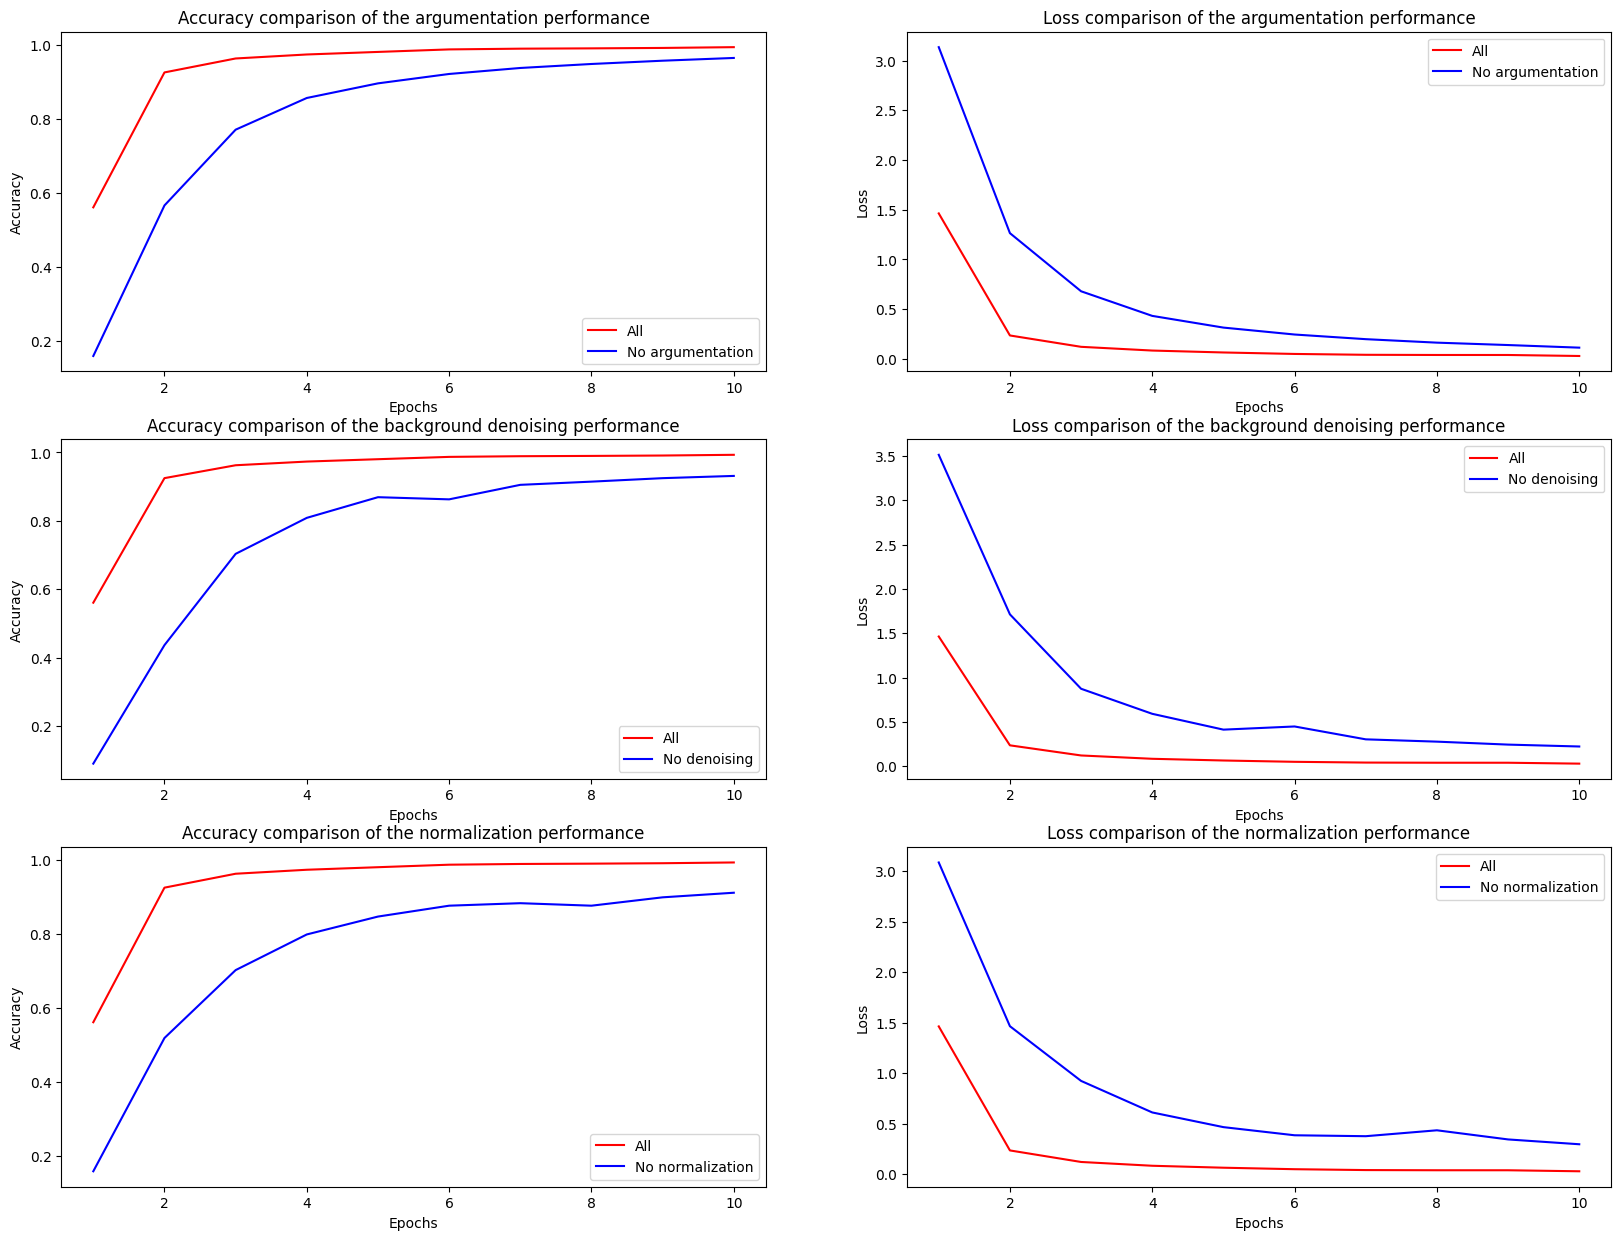

In [21]:
acc_1, loss_1 = history_1.history['accuracy'], history_1.history['loss']
acc_2, loss_2 = history_2.history['accuracy'], history_2.history['loss']
acc_3, loss_3 = history_3.history['accuracy'], history_3.history['loss']
acc_4, loss_4 = history_4.history['accuracy'], history_4.history['loss']

# Generate the comparison graph
epochs = range(1, 11)  
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
plt.plot(epochs, acc_1, label='All', color='red')
plt.plot(epochs, acc_2, label='No argumentation', color='blue')
plt.title('Accuracy comparison of the argumentation performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, loss_1, label='All', color='red')
plt.plot(epochs, loss_2, label='No argumentation', color='blue')
plt.title('Loss comparison of the argumentation performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epochs, acc_1, label='All', color='red')
plt.plot(epochs, acc_4, label='No denoising', color='blue')
plt.title('Accuracy comparison of the background denoising performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs, loss_1, label='All', color='red')
plt.plot(epochs, loss_4, label='No denoising', color='blue')
plt.title('Loss comparison of the background denoising performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epochs, acc_1, label='All', color='red')
plt.plot(epochs, acc_3, label='No normalization', color='blue')
plt.title('Accuracy comparison of the normalization performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epochs, loss_1, label='All', color='red')
plt.plot(epochs, loss_3, label='No normalization', color='blue')
plt.title('Loss comparison of the normalization performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
